In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
from sensor import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
#%matplotlib notebook

In [2]:
class DstarLite():
    def __init__(
        self, world, sensor,
        drawCost_flag=False, drawTakenPath_flag=True, drawPathToTake_flag=True, drawMetricMap_flag=False, cost_adj=13
    ):
        self.world = world
        self.real_grid_map = world.grid_map #実際のマップ
        self.sensor = sensor
        
        self.drawCost_flag = drawCost_flag
        self.drawPathToTake_flag = drawPathToTake_flag
        self.drawMetricMap_flag = drawMetricMap_flag
        self.drawTakenPath_flag = drawTakenPath_flag
        self.cost_adj = cost_adj
        self.pp_algorithm_name = "DstarLite"
        
        self.initialize()
        
    def initialize(self):
        self.metric_grid_map = np.full(self.real_grid_map.shape, -1)  #測定により得られたマップ
        self.cost_map = np.full(self.real_grid_map.shape, 1)    #その地点が持つコスト
        self.id_map = np.full(self.real_grid_map.shape, 0)
        self.g_map = np.full(self.real_grid_map.shape, float('inf'))
        self.rhs_map = np.full(self.real_grid_map.shape, float('inf'))
        
        self.U = []
        self.km = 0.0
        self.previousIndex = self.world.start_index
        self.currentIndex = self.world.start_index
        self.pathToTake = []
        self.takenPath = []
        
        grid_id = 0
        for index, grid in np.ndenumerate(self.real_grid_map):
            self.id_map[index[0]][index[1]] = grid_id
            if(grid == '3' or self.world.isGoal(index)):
                self.rhs_map[index[0]][index[1]] = 0
                self.uAppend(index, [self.h(self.world.start_index, self.world.goal_index), 0])
            elif(grid == "2" or self.world.isStart(index)):
                self.metric_grid_map[index[0]][index[1]] = 0
            grid_id += 1
        self.computeShortestPath(self.world.start_index)
        
    def draw(self, ax, elems):
        #if(self.g(self.currentIndex) == float('inf')):
        #    return
        
        # Check New Obstacle -> Move to Next Index
        self.checkNewObstacle(self.currentIndex)
        self.currentIndex = self.next(self.currentIndex)
        self.getPathToTake(self.currentIndex)
        self.drawNewObstacles(ax, elems) if(not self.drawMetricMap_flag) else None
        self.drawMetricMap(ax, elems) if(self.drawMetricMap_flag) else None
        self.drawPathToTake(ax, elems) if(self.drawPathToTake_flag) else None
        self.drawRobot(ax, elems)
        self.drawCost(ax, elems, cost_adj) if(self.drawCost_flag) else None
    
    def plot(self, figsize=(4, 4), save_path=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map):
            if grid == '0':
                self.world.drawGrid(index, "black", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal
                self.world.drawGrid(index, "green", 1.0, ax)
        
        for index in self.takenPath:
            if (not self.world.isStart(index)) and (not self.world.isGoal(index)):
                self.world.drawGrid(index, "red", 0.5, ax)
        
        plt.show()

        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig
    
    def next(self, index):
        if self.world.isGoal(index):
            return index
        min_cost = float('inf')
        next_index = index
        for grid in neigbor_grids:
            s_dash = index + grid
            if self.world.isOutOfBounds(s_dash):
                continue
            if(min_cost >= self.c(index, s_dash) + self.g(s_dash)):
                #if(self.pres_index != s_dash):
                min_cost = self.c(index, s_dash) + self.g(s_dash)
                next_index = s_dash
        return next_index
    
    def run(self):
        self.initialize()
        while not self.world.isGoal(self.currentIndex):
            self.checkNewObstacle(self.currentIndex)
            self.currentIndex = self.next(self.currentIndex)
            self.takenPath.append(self.currentIndex)
            
    def checkNewObstacle(self, index):
        obstacles = self.sensor.sense(index)
        self.newObstacles = [obstacle[0] for obstacle in obstacles]
        for u, occupancy in obstacles:
            prev_u_obs_flag = self.isObservedObstacle(u)
            self.metric_grid_map[u[0]][u[1]] = occupancy
            for grid in neigbor_grids:
                v = u + grid
                if self.world.isOutOfBounds(v):
                    continue
                c_old = self.c(u, v)

                if prev_u_obs_flag or self.isObservedObstacle(v):
                    c_old = float('inf')
                else:
                    c_old = 1.41 if(np.all(np.abs(u - v) == [1, 1])) else 1.0

                if(c_old > self.c(u, v)):
                    if not self.world.isGoal(u):
                        self.rhs_map[u[0]][u[1]] = min(self.rhs(u), self.c(u, v)+self.g(v))
                elif(self.rhs(u) == c_old + self.g(v)):
                    if not self.world.isGoal(u):
                        self.rhs_map[u[0]][u[1]] = self.getMinRhs(u)
                self.updateVertex(u)

                if(c_old > self.c(v, u)):
                    if not self.world.isGoal(v):
                        self.rhs_map[v[0]][v[1]] = min(self.rhs(v), self.c(v, u)+self.g(u))
                elif(self.rhs(v) == c_old + self.g(u)):
                    if not self.world.isGoal(v):
                        self.rhs_map[v[0]][v[1]] = self.getMinRhs(v)
                self.updateVertex(v)
                  
        if len(self.newObstacles) > 0:
            self.km = self.km + self.h(self.previousIndex, index)
            self.previousIndex = self.currentIndex
            self.computeShortestPath(index)
    
    def getPathToTake(self, robot_index):#今後の経路を描画
        self.pathToTake = [robot_index]
        while not self.world.isGoal(robot_index):
            next_index = robot_index
            min_cost = float('inf')
            for grid in neigbor_grids:
                s_dash = robot_index + grid
                if self.world.isOutOfBounds(s_dash) or self.isObservedObstacle(s_dash) or np.any(np.all(self.pathToTake==s_dash, axis=1)):
                    continue
                if min_cost >= self.c(robot_index, s_dash) + self.rhs(s_dash):
                    min_cost = self.c(robot_index, s_dash) + self.rhs(s_dash)
                    next_index = s_dash
            robot_index = next_index
            if np.any(np.all(self.pathToTake==robot_index, axis=1)):
                break
            self.pathToTake.append(robot_index)
    
    def computeShortestPath(self, index):
        while(1):
            U_row = [row[1] for row in self.U]
            u_data = min(U_row)
            idx = U_row.index(u_data)
            u, k_old = np.array(self.U[idx][0]), self.U[idx][1]
            k_new = self.calculateKey(u)
                
            if(k_old >= self.calculateKey(index) and self.rhs(index) <= self.g(index)):
                break
            
            if(k_old < k_new):
                self.uUpdate(u, k_new)
            elif(self.g(u) > self.rhs(u)):
                self.g_map[u[0]][u[1]] = self.rhs(u)
                self.uRemove(u)
                for grid in neigbor_grids:
                    s = u + grid
                    if self.world.isOutOfBounds(s):
                        continue
                    if not self.world.isGoal(s):
                        self.rhs_map[s[0]][s[1]] = min(self.rhs(s), self.c(s, u)+self.g(u))
                    self.updateVertex(s)
            else:
                g_old = self.g(u)
                self.g_map[u[0]][u[1]] = float('inf')
                for grid in neigbor_grids + [[0, 0]]:
                    s = u + grid
                    if(self.world.isOutOfBounds(s)):
                        continue
                    if(self.rhs(s) == self.c(s, u) + g_old):
                        if not self.world.isGoal(s):
                            self.rhs_map[s[0]][s[1]] = self.getMinRhs(s)
                    self.updateVertex(s)
    
    def calculateKey(self, s):
        return [min(self.g(s), self.rhs(s)) + self.h(self.world.start_index, s) + self.km, min(self.g(s), self.rhs(s))]
    
    def updateVertex(self, u):
        u_flag = list(u) in [row[0] for row in self.U]
        if(self.g(u) != self.rhs(u) and u_flag):
            self.uUpdate(u, self.calculateKey(u))
        elif(self.g(u) != self.rhs(u) and u_flag == False):
            self.uAppend(u, self.calculateKey(u))
        elif(self.g(u) == self.rhs(u) and u_flag):
            self.uRemove(u)
    
    def uAppend(self, u, u_num):
        self.U.append([list(u), u_num])
    
    def uRemove(self, u):
        U_row = [row[0] for row in self.U]
        idx = U_row.index(list(u))
        self.U.remove([list(u), self.U[idx][1]])
    
    def uUpdate(self, u, u_num_new):
        U_row = [row[0] for row in self.U]
        idx = U_row.index(list(u))
        self.U[idx][1] = u_num_new
    
    def getMinRhs(self, u):
        min_rhs = float('inf')
        for grid in neigbor_grids:
            v = u + grid
            if self.world.isOutOfBounds(v):
                continue
            if(min_rhs > self.c(u, v)+self.g(v)):
                min_rhs = self.c(u, v)+self.g(v)
        return min_rhs
    
    def rhs(self, s):
        return self.rhs_map[s[0]][s[1]]
    
    def g(self, s):
        return self.g_map[s[0]][s[1]]
    
    def c(self, index, neigbor_index): #隣接ノードへ移動するのに要するコスト
        if self.isObservedObstacle(index) or self.isObservedObstacle(neigbor_index):
            return float('inf')
        else:
            return 1.41 if(np.all(np.abs(index - neigbor_index) == [1, 1])) else 1.0

    def h(self, s1, s2):
        return 1.0 * np.linalg.norm(s1 - s2)
    
    def isU(self, u):
        U_row = [row[0] for row in self.U]
        return list(u) in U_row
    
    def isUnobserved(self, index):
        if self.metric_grid_map[index[0]][index[1]] == -1:
            return True
        else:
            return False
    
    def isObservedObstacle(self, index):
        #if self.metric_grid_map[index[0]][index[1]] == '0':
        if self.metric_grid_map[index[0]][index[1]] > 0.3:
            return True
        else:
            return False
    
    def drawNewObstacles(self, ax, elems):
        for index in self.newObstacles:
            self.world.drawGrid(index, "black", 1.0, ax, fill=True)
    
    def drawPathToTake(self, ax, elems):
        for n in self.pathToTake:
            if (not self.world.isStart(n)) and (not self.world.isGoal(n)):
                self.world.drawGrid(n, "red", 0.5, ax, elems=elems)
    
    def drawCost(self, ax, elems, cost_adj):
        for index, _ in np.ndenumerate(self.metric_grid_map):
            if(self.rhs(index) < 100000):    #LOWER状態のセルを描画
                c_num = int(self.rhs(index)) #Black→Blue
                c_num = int(c_num * cost_adj)
                if(c_num > 0xff): #Blue → Cyan
                    c_num = (c_num-0xff)*16*16 + 0xff
                    if(c_num > 0xffff): #Cyan → Green
                        c_num = 0xffff - int((c_num-0x100ff)*4/256)
                        if(c_num < 0xff00): #Green →Yellow
                            c_num = (0xff00-c_num)*65536+0xff00
                            if(c_num > 0xffff00): #Yellow → Red
                                c_num = 0xffff00 - int((c_num-0xffff00)*0.5/65536)*256
                fill = True
                alpha = 0.5
                c = '#' + format(int(c_num), 'x').zfill(6)
                self.world.drawGrid(index, c, alpha, ax, fill, elems)
            else:    #RAISE状態のセルを描画
                #self.world.drawGrid(index, "red", 1.0, ax. True, elems)
                continue
                
    def drawRobot(self, ax, elems):
        if not(self.world.isStart(self.currentIndex)) and not(self.world.isGoal(self.currentIndex)):
            self.world.drawGrid(self.currentIndex, "magenta", 0.5, ax) if(self.drawTakenPath_flag) else None
            self.world.drawGrid(self.currentIndex, "blue", 1.0, ax, elems=elems)
        
    def drawMetricMap(self, ax, elems):
        for index, grid in np.ndenumerate(self.metric_grid_map):
            if(grid == "1"):
                continue
            elif(grid == "-1"):
                c = "lightgray"
            elif(grid == "0"):
                c = "black"
            self.world.drawGrid(index, c, 1.0, ax, elems=elems)
        self.world.drawGrid(self.world.goal_index, "green", 1.0, ax, elems=elems)

<IPython.core.display.Javascript object>


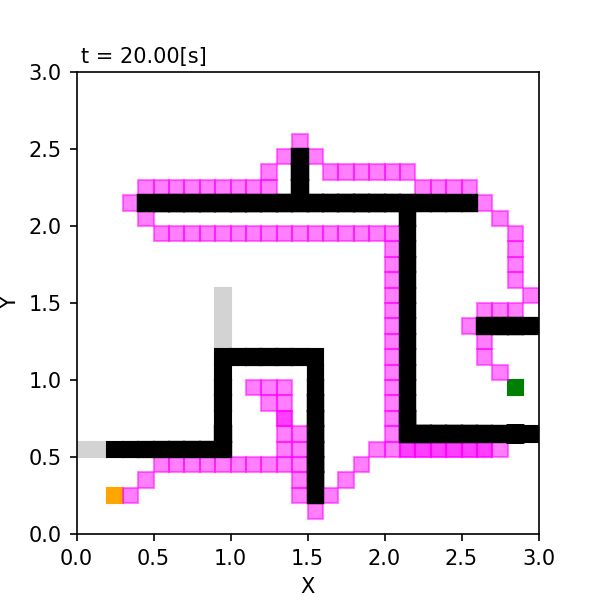

In [3]:
if __name__ == "__main__":
    time_span = 20
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map2.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", debug=False, is_dynamic=True)
    
    cost_adj = 13   #map_2
    #cost_adj = 16   #map_3
    #cost_adj = 4    #map_large
    sensor = IdealSensor(world)
    world.append(DstarLite(world, sensor, cost_adj=cost_adj))
    
    world.draw()
    #world.ani.save('dstarlite_map5.gif', writer='pillow', fps=100)    #アニメーション保存